## EDA LAB

The General Social Survey (GSS) is a bi-annual nationally representative survey of Americans, with almost 7000 different questions asked since the survey began in the 1970s. It has straightforward questions about respondents' demographic information, but also questions like "Does your job regularly require you to perform repetitive or forceful hand movements or involve awkward postures?" or "How often do the demands of your job interfere with your family life?" There are a variety of controversial questions. No matter what you're curious about, there's something interesting in here to check out. The codebook is 904 pages (use CTRL+F to search it).

The data and codebook are available at:
https://gss.norc.org/us/en/gss/get-the-data.html

The datasets are so large that it might make sense to pick the variables you want, and then download just those variables from:
https://gssdataexplorer.norc.org/variables/vfilter

Here is your task:
1. Download a small (5-15) set of variables of interest.
2. Write a short description of the data you chose, and why. (1 page)
3. Load the data using Pandas. Clean them up for EDA. Do this in a notebook with comments or markdown chunks explaining your choices.
4. Produce some numeric summaries and visualizations. (1-3 pages)
5. Describe your findings in 1-2 pages.
6. If you have other content that you think absolutely must be included, you can include it in an appendix of any length.

For example, you might want to look at how aspects of a person's childhood family are correlated or not with their career or family choices as an adult. Or how political or religious affiliations correlate with drug use or sexual practices. It's an extremely wide-ranging survey.

Feel free to work with other people in groups, and ask questions!

Shape: (75699, 7)
Columns: ['year', 'id_', 'satfrnd', 'contv', 'tvhours', 'newsfrom', 'ballot']

Missingness after cleaning:
             missing_rate
tvhours_num      0.390362
year             0.000000
contv            0.000000
newsfrom         0.000000
satfrnd          0.000000


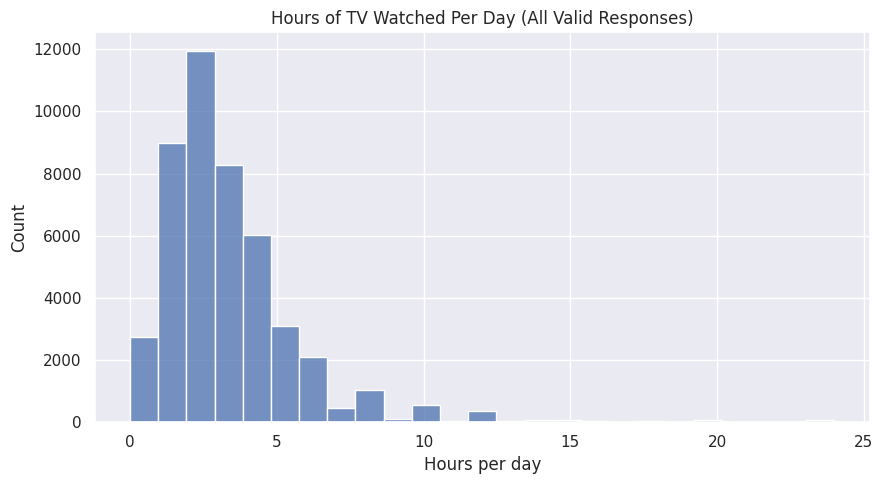

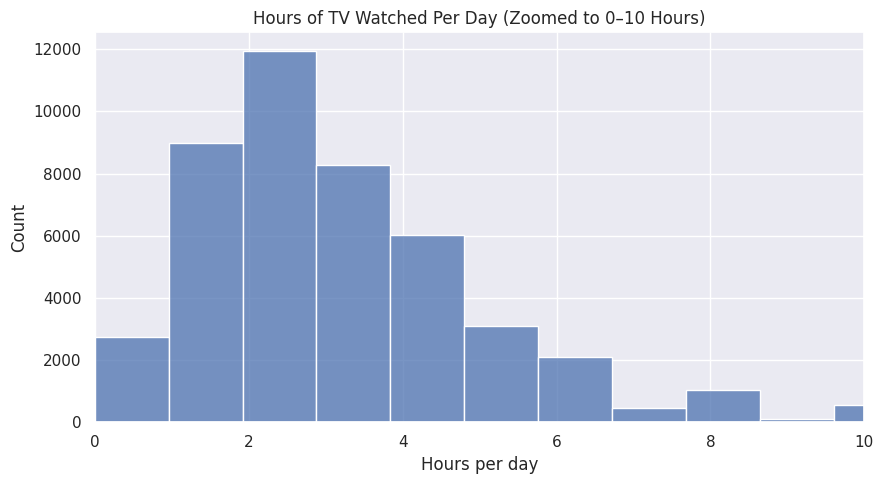

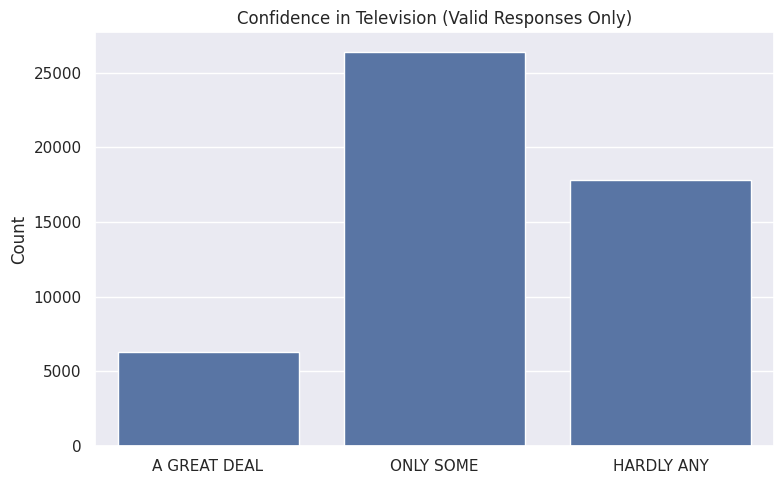

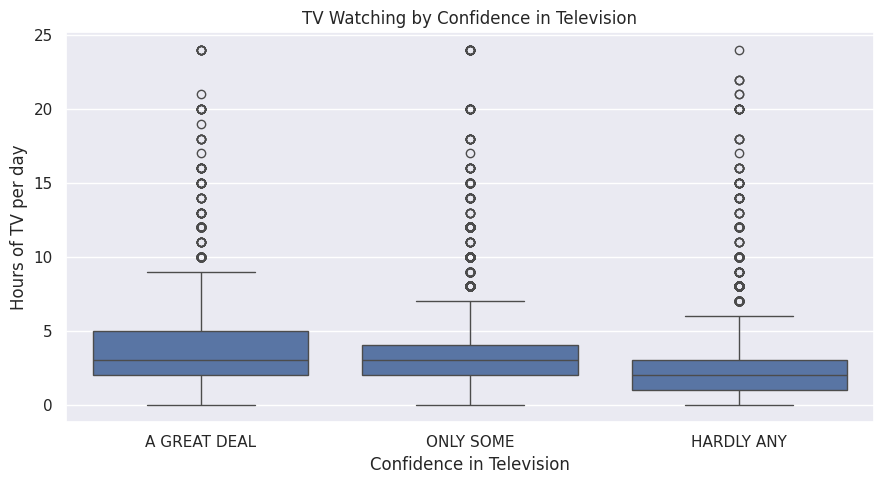

/tmp/ipython-input-1055588696.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Satisfaction", bbox_to_anchor=(1.02, 1), loc="upper left")


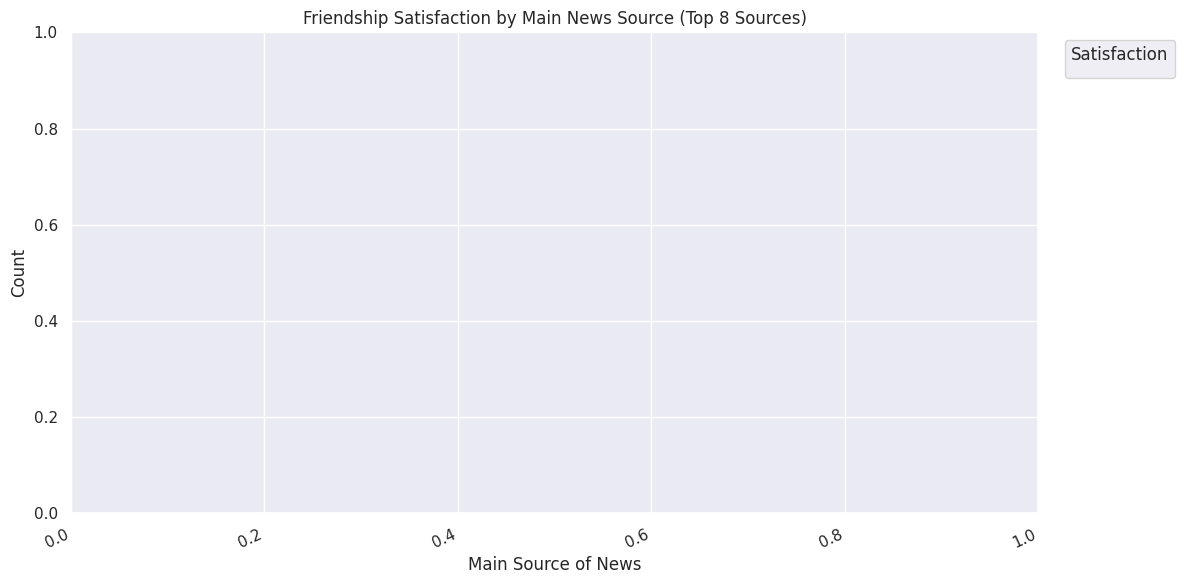

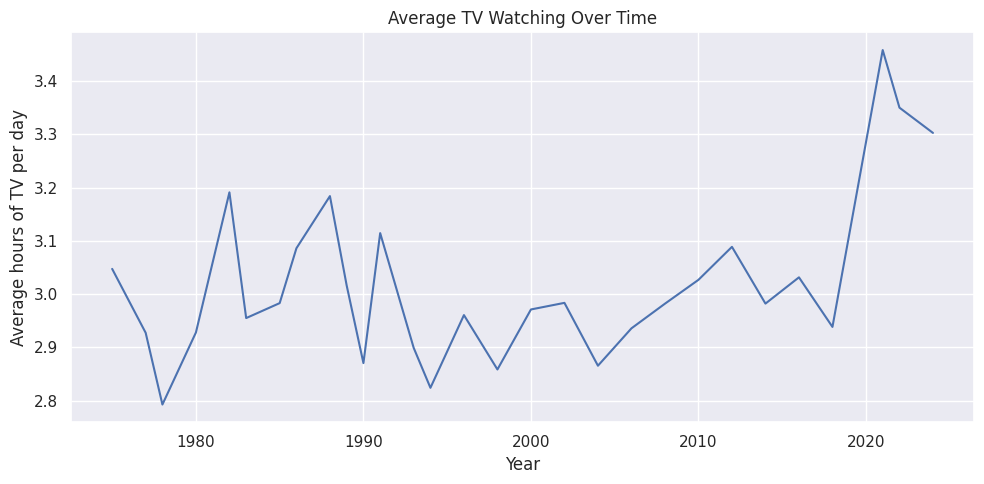


TV hours summary (valid only):
count    46149.000000
mean         3.035624
std          2.561582
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         24.000000
Name: tvhours_num, dtype: float64

Top news sources among valid responses:
newsfrom
Tv                              0.447721
The internet                    0.294139
Newspaper                       0.144583
Radio                           0.059917
Family                          0.018472
Friends/colleagues              0.016578
Magazines                       0.006868
Books/other printed material    0.004500
Other                           0.004144
Government agencies             0.001776
Name: proportion, dtype: float64

Friendship satisfaction (valid only):
satfrnd
GREAT DEAL                   0.394430
VERY GREAT DEAL              0.301275
QUITE A BIT                  0.151548
A FAIR AMOUNT                0.094231
SOME                         0.030169
A LITTLE                    

In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("/content/GSS1.xlsx")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

def clean_gss_label(x):
    """Convert values like '.i: Inapplicable' or '1: A GREAT DEAL' to clean text."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # If it looks like 'something: label', keep the label portion
    if ":" in s:
        left, right = s.split(":", 1)
        # left might be '.i' or '1' etc; we keep right
        return right.strip()
    return s

def to_numeric_hours(x):
    """Extract numeric hours from tvhours; return NaN for non-numeric labels."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # pick the first number found (e.g., '3' or '3.5')
    m = re.search(r"(\d+(\.\d+)?)", s)
    return float(m.group(1)) if m else np.nan


# Year should be numeric
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Clean categorical labels (whether they’re already clean or in "code: label" format)
for col in ["contv", "newsfrom", "satfrnd", "ballot"]:
    if col in df.columns:
        df[col] = df[col].apply(clean_gss_label)

# tvhours: force numeric
df["tvhours_num"] = df["tvhours"].apply(to_numeric_hours)

# Remove impossible tv hours (GSS should be 0–24)
df.loc[(df["tvhours_num"] < 0) | (df["tvhours_num"] > 24), "tvhours_num"] = np.nan

# Define "junk" responses to exclude from plots
junk = {
    "Inapplicable",
    "Not available in this year",
    "No answer",
    "Don't know",
    "Cant choose",
    "Cannot choose",
    "Skipped on Web"
}

def valid_cat(s):
    return (~s.isna()) & (~s.isin(junk))

# Print missingness after cleaning (useful for your writeup)
print("\nMissingness after cleaning:")
print(pd.DataFrame({
    "missing_rate": df[["year","tvhours_num","contv","newsfrom","satfrnd"]].isna().mean()
}).sort_values("missing_rate", ascending=False))


sns.set_theme()

# 1) TV hours distribution (trim x-axis to show the bulk + keep full range optional)
tv = df["tvhours_num"].dropna()

plt.figure(figsize=(9,5))
sns.histplot(tv, bins=25)
plt.title("Hours of TV Watched Per Day (All Valid Responses)")
plt.xlabel("Hours per day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
sns.histplot(tv, bins=25)
plt.xlim(0, 10)
plt.title("Hours of TV Watched Per Day (Zoomed to 0–10 Hours)")
plt.xlabel("Hours per day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


contv_order = ["A GREAT DEAL", "ONLY SOME", "HARDLY ANY"]
contv_plot = df.loc[valid_cat(df["contv"]), "contv"]
contv_plot = contv_plot[contv_plot.isin(contv_order)]

plt.figure(figsize=(8,5))
sns.countplot(x=contv_plot, order=contv_order)
plt.title("Confidence in Television (Valid Responses Only)")
plt.xlabel("")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3) TV hours by confidence (valid only + ordered)
plot3 = df.loc[valid_cat(df["contv"]) & df["contv"].isin(contv_order), ["contv","tvhours_num"]].dropna()

plt.figure(figsize=(9,5))
sns.boxplot(x="contv", y="tvhours_num", data=plot3, order=contv_order)
plt.title("TV Watching by Confidence in Television")
plt.xlabel("Confidence in Television")
plt.ylabel("Hours of TV per day")
plt.tight_layout()
plt.show()

news_valid = df.loc[valid_cat(df["newsfrom"]), "newsfrom"]
top_news = news_valid.value_counts().head(8).index.tolist()

plot4 = df.loc[valid_cat(df["newsfrom"]) & df["newsfrom"].isin(top_news), ["newsfrom","satfrnd"]].copy()
plot4 = plot4.loc[valid_cat(plot4["satfrnd"])].dropna()


sat_order = ["A VERY GREAT DEAL", "A GREAT DEAL", "QUITE A BIT", "A FAIR AMOUNT", "A LITTLE", "NONE"]
plot4["satfrnd"] = pd.Categorical(plot4["satfrnd"], categories=sat_order, ordered=True)

plt.figure(figsize=(12,6))
sns.countplot(data=plot4, x="newsfrom", hue="satfrnd", order=top_news)
plt.title("Friendship Satisfaction by Main News Source (Top 8 Sources)")
plt.xlabel("Main Source of News")
plt.ylabel("Count")
plt.xticks(rotation=25, ha="right")
plt.legend(title="Satisfaction", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 5) Average TV hours over time (valid tvhours only)
plot5 = df.dropna(subset=["year","tvhours_num"]).groupby("year", as_index=False)["tvhours_num"].mean()

plt.figure(figsize=(10,5))
sns.lineplot(data=plot5, x="year", y="tvhours_num", errorbar=None)
plt.title("Average TV Watching Over Time")
plt.xlabel("Year")
plt.ylabel("Average hours of TV per day")
plt.tight_layout()
plt.show()

print("\nTV hours summary (valid only):")
print(tv.describe())

print("\nTop news sources among valid responses:")
print(news_valid.value_counts(normalize=True).head(10))

print("\nFriendship satisfaction (valid only):")
sat_valid = df.loc[valid_cat(df["satfrnd"]), "satfrnd"]
print(sat_valid.value_counts(normalize=True))


Across the full dataset, a major first takeaway is that several variables are not asked every year, which creates a large share of responses labeled “Inapplicable” or “Not available in this year.” This is especially visible for newsfrom and satfrnd in your printed distributions, where a majority of rows fall into non-response categories. For exploratory analysis, it makes the most sense to restrict visualizations to valid responses only (i.e., excluding inapplicable, not asked, and “don’t know” categories). After filtering those out, the remaining sample provides a clearer picture of how respondents report TV consumption, confidence in television, news habits, and friendship satisfaction in the years those questions were actually fielded.

Looking at TV viewing behavior (tvhours), the distribution of daily viewing is right-skewed: most respondents report a relatively low to moderate number of hours per day, while a smaller group reports much higher viewing. This is typical for time-use variables and suggests meaningful heterogeneity in media consumption. When plotting the histogram with a zoomed x-axis (0–10 hours), the bulk of responses becomes much easier to interpret, while the full-range plot still captures the long tail. In other words, a small number of heavy-viewing respondents can visually dominate the scale unless you either zoom or treat them as a tail/outliers.

Confidence in television (contv) shows a distribution that is concentrated in the middle categories rather than overwhelmingly at one extreme. When comparing TV hours by confidence category (boxplots), the relationship is not clean or deterministic: each confidence group contains a wide spread of TV hours, and the ranges overlap heavily. That means you shouldn’t claim a strong “more confidence → more TV” story from EDA alone. The safer interpretation is that confidence and consumption are related in a messy, high-variance way—if there is an association, it is not strong enough to separate groups cleanly in exploratory plots.

Finally, when comparing friendship satisfaction (satfrnd) across main news sources (newsfrom), the clearest EDA move is to limit the plot to the top 6–8 news sources so the visualization remains readable. Even after restricting to those common categories and valid responses, the differences in friendship satisfaction appear modest, with substantial overlap between groups—suggesting that news source is not a strong standalone separator of social satisfaction. The more meaningful conclusion for this lab is methodological: once you remove “inapplicable/not asked” responses and keep the category set manageable, the remaining data support careful descriptive comparisons, but the patterns look nuanced rather than dramatic.